In [9]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '../data/raw/phishing_data.csv'

print("Caricamento dati...")

try:
    # Carica i dati
    df = pd.read_csv(file_path)
    print("Dataset caricato con successo!")

    print(f"Righe totali: {df.shape[0]}")
    print(f"Colonne totali: {df.shape[1]}")

    print("\n--- NOMI DELLE COLONNE ---")
    print(list(df.columns))

    print("\n--- ANTEPRIMA ---")
    print(df.head())

except FileNotFoundError:
    print("ERRORE: File non trovato!")
    print("Controlla che il file si chiami 'phishing_data.csv' e sia dentro 'data/raw'")
except Exception as e:
    print(f"Altro errore: {e}")

Caricamento dati...
Dataset caricato con successo!
Righe totali: 235795
Colonne totali: 56

--- NOMI DELLE COLONNE ---
['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfE

Dataset pulito, ora abbiamo 51 colonne (prima erano 56).
Righe dopo la rimozione duplicati: 234987

Distribuzione delle classi:
label
1    134850
0    100137
Name: count, dtype: int64


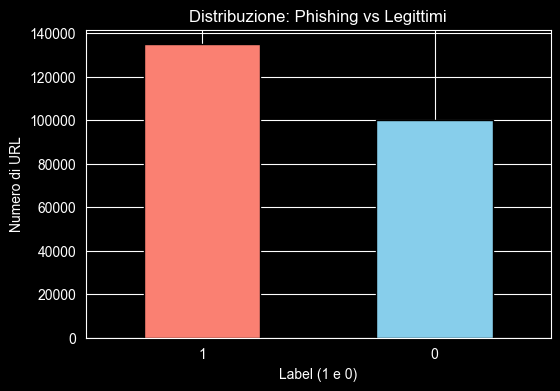

In [10]:
# Rimozione delle colonne inutili o testuali che non verranno usate
# FILENAME: inutile ID
# URL, Domain, TLD, Title: sono testo, userà le loro versioni numeriche (es. URLLength)
cols_to_drop = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']

# Crea un nuovo dataset pulito
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Dataset pulito, ora abbiamo {df_clean.shape[1]} colonne (prima erano 56).")

# Se ci sono duplicati, li rimuove
df_clean = df_clean.drop_duplicates()
print(f"Righe dopo la rimozione duplicati: {df_clean.shape[0]}")

# Conta quanti sono i Label 1 e i Label 0
conteggio_target = df_clean['label'].value_counts()
print("\nDistribuzione delle classi:")
print(conteggio_target)

# Realizzazione di un grafico a barre
plt.figure(figsize=(6,4))
conteggio_target.plot(kind='bar', color=['salmon', 'skyblue'], edgecolor='black')
plt.title("Distribuzione: Phishing vs Legittimi")
plt.xlabel("Label (1 e 0)")
plt.ylabel("Numero di URL")
plt.xticks(rotation=0)
plt.show()

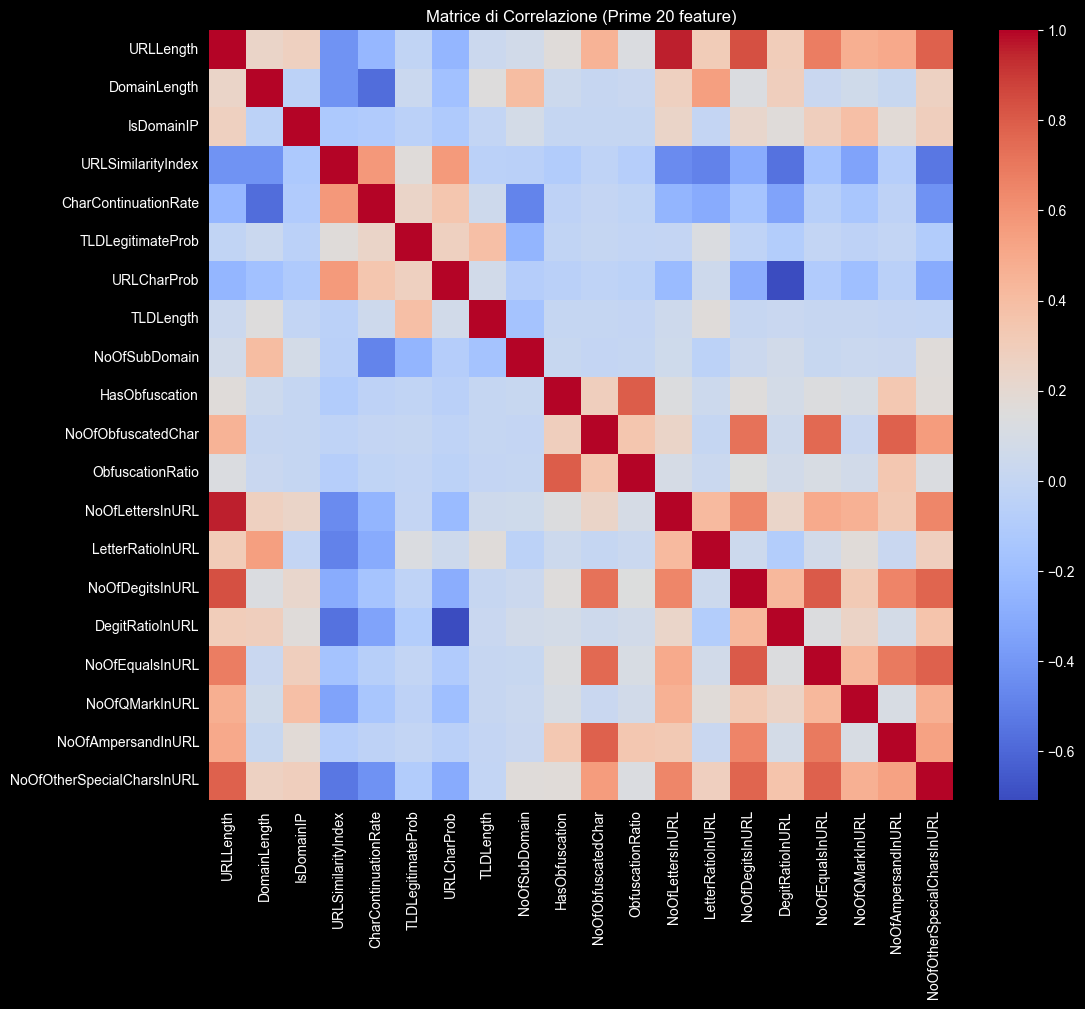


Top 10 colonne correlate con il Phishing:
label                    1.000000
URLSimilarityIndex       0.859856
HasSocialNet             0.783543
HasCopyrightInfo         0.742593
HasDescription           0.689297
IsHTTPS                  0.612415
DomainTitleMatchScore    0.583288
HasSubmitButton          0.577442
IsResponsive             0.552127
URLTitleMatchScore       0.537578
Name: label, dtype: float64


In [11]:
# Crea una Heatmap che mostra quali variabili sono legate alla label
import seaborn as sns

# Calcola la correlazione solo tra le prime 20 colonne, 51 son troppe
corr_matrix = df_clean.iloc[:, :20].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Matrice di Correlazione (Prime 20 feature)")
plt.show()

# Quali colonne hanno la correlazione più alta con la 'label'
correlazione_con_label = df_clean.corr()['label'].sort_values(ascending=False)
print("\nTop 10 colonne correlate con il Phishing:")
print(correlazione_con_label.head(10))

Preparazione dei dati per il modello...
Dati di Training: 164490 esempi
Dati di Test: 70497 esempi

Addestramento dell'Albero Decisionale...
Modello addestrato!

Valutazione performance...
ACCURACY: 100.00%


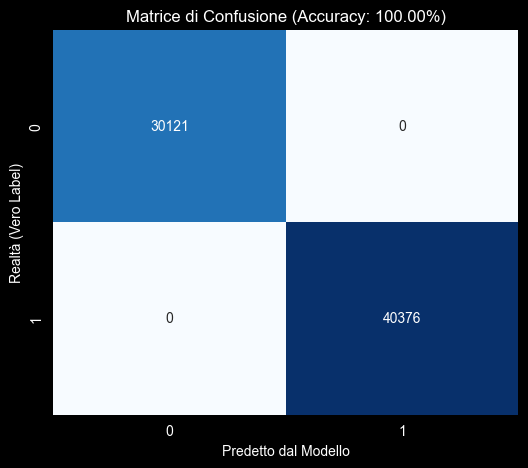


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30121
           1       1.00      1.00      1.00     40376

    accuracy                           1.00     70497
   macro avg       1.00      1.00      1.00     70497
weighted avg       1.00      1.00      1.00     70497



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


print("Preparazione dei dati per il modello...")

# X sono le domande, tranne quindi la label
# y è la label
X = df_clean.drop(columns=['label'])
y = df_clean['label']

# Dividiamo: 70% Train, 30% Test (random_state=42 per mescolarli sempre allo stesso modo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dati di Training: {X_train.shape[0]} esempi")
print(f"Dati di Test: {X_test.shape[0]} esempi")

print("\nAddestramento dell'Albero Decisionale...")

# Creazione dell'albero.
# max_depth=10: 10 domande per evitare overfitting, che impari a memoria
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
model.fit(X_train, y_train)
print("Modello addestrato!")

print("\nValutazione performance...")

# Vengono fatte previsioni sui dati che il modello non ha visto (Test set)
y_pred = model.predict(X_test)

# Calcolo dell'accuratezza
acc = accuracy_score(y_test, y_pred)
print(f"ACCURACY: {acc*100:.2f}%")

# Matrice di Confusione
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matrice di Confusione (Accuracy: {acc*100:.2f}%)')
plt.xlabel('Predetto dal Modello')
plt.ylabel('Realtà (Vero Label)')
plt.show()

# Report: Precision, Recall, F1
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

Analisi di come ragiona il modello...

--- TOP 10 COLONNE DECISIVE ---
URLSimilarityIndex: 0.9866
LineOfCode: 0.0130
IsHTTPS: 0.0004
NoOfSubDomain: 0.0000
NoOfCSS: 0.0000
NoOfImage: 0.0000
NoOfSelfRef: 0.0000
NoOfJS: 0.0000
Pay: 0.0000
Bank: 0.0000


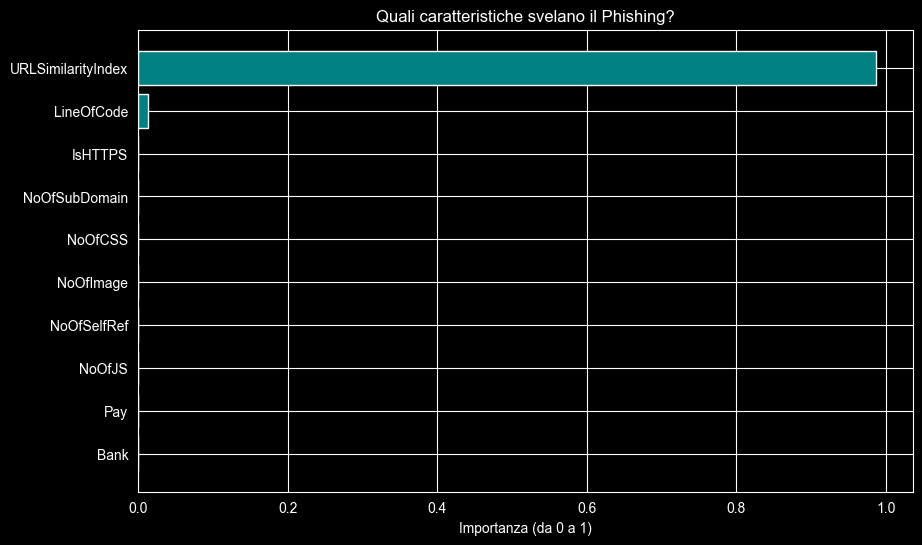

In [13]:
import numpy as np

print("Analisi di come ragiona il modello...")

# Bisogna vedere l'importanza di ogni colonna
importances = model.feature_importances_
feature_names = X.columns

# Ordinamento dalla più importante alla meno importante
indices = np.argsort(importances)[::-1]

# Meglio solo le Top 10
top_n = 10
top_indices = indices[:top_n]

print("\n--- TOP 10 COLONNE DECISIVE ---")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.title("Quali caratteristiche svelano il Phishing?")
plt.barh(range(top_n), importances[top_indices], align="center", color='teal')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.xlabel("Importanza (da 0 a 1)")
plt.gca().invert_yaxis() # Mette la più importante in alto
plt.show()

Bisogna rimuovere 'URLSimilarityIndex' e riprovare...
Addestramento nuovo modello...

NUOVA ACCURACY REALE: 99.88%

--- COSA GUARDA ORA IL MODELLO? (Top 10)---
NoOfExternalRef: 0.8511
NoOfSelfRef: 0.0627
NoOfOtherSpecialCharsInURL: 0.0320
IsHTTPS: 0.0163
LineOfCode: 0.0105
HasSocialNet: 0.0088
NoOfSubDomain: 0.0087
NoOfImage: 0.0024
NoOfDegitsInURL: 0.0014
CharContinuationRate: 0.0013


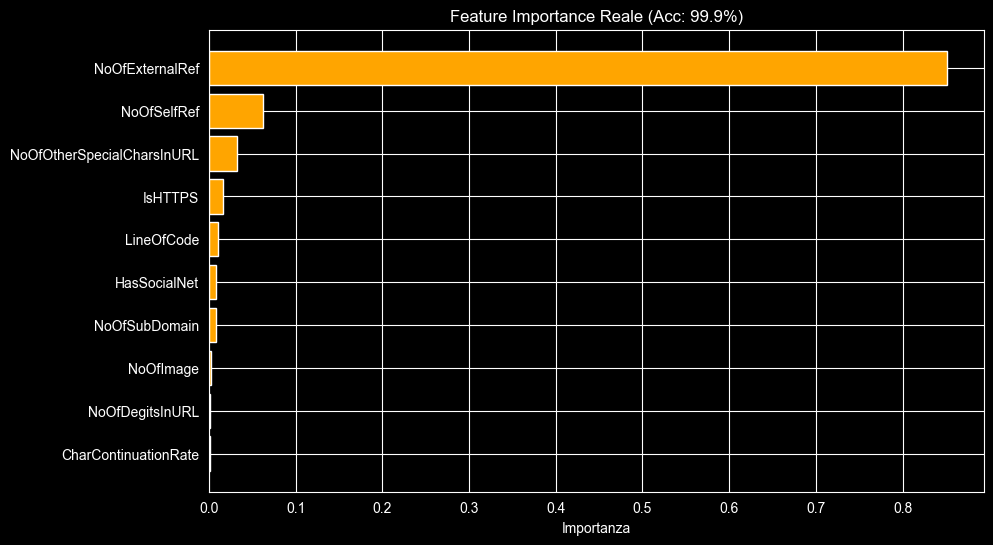

In [14]:
print("Bisogna rimuovere 'URLSimilarityIndex' e riprovare...")

# Rimozione di URLSimilarityIndex
X_real = X.drop(columns=['URLSimilarityIndex'])

# Ora split con i dati real
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y, test_size=0.3, random_state=42)

# Riaddestramento dell'Albero
print("Addestramento nuovo modello...")
model_real = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
model_real.fit(X_train_real, y_train_real)

# Valutazione
y_pred_real = model_real.predict(X_test_real)
acc_real = accuracy_score(y_test_real, y_pred_real)

print(f"\nNUOVA ACCURACY REALE: {acc_real*100:.2f}%")

# nuova classifica
importances_real = model_real.feature_importances_
indices_real = np.argsort(importances_real)[::-1]
top_n = 10
top_indices_real = indices_real[:top_n]

print("\n--- COSA GUARDA ORA IL MODELLO? (Top 10)---")
feature_names_real = X_real.columns
for i in top_indices_real:
    print(f"{feature_names_real[i]}: {importances_real[i]:.4f}")

# Grafico
plt.figure(figsize=(10, 6))
plt.title(f"Feature Importance Reale (Acc: {acc_real*100:.1f}%)")
plt.barh(range(top_n), importances_real[top_indices_real], align="center", color='orange')
plt.yticks(range(top_n), [feature_names_real[i] for i in top_indices_real])
plt.xlabel("Importanza")
plt.gca().invert_yaxis()
plt.show()

Addestriamo una Random Forest (100 alberi)...
ACCURACY RANDOM FOREST: 99.99%


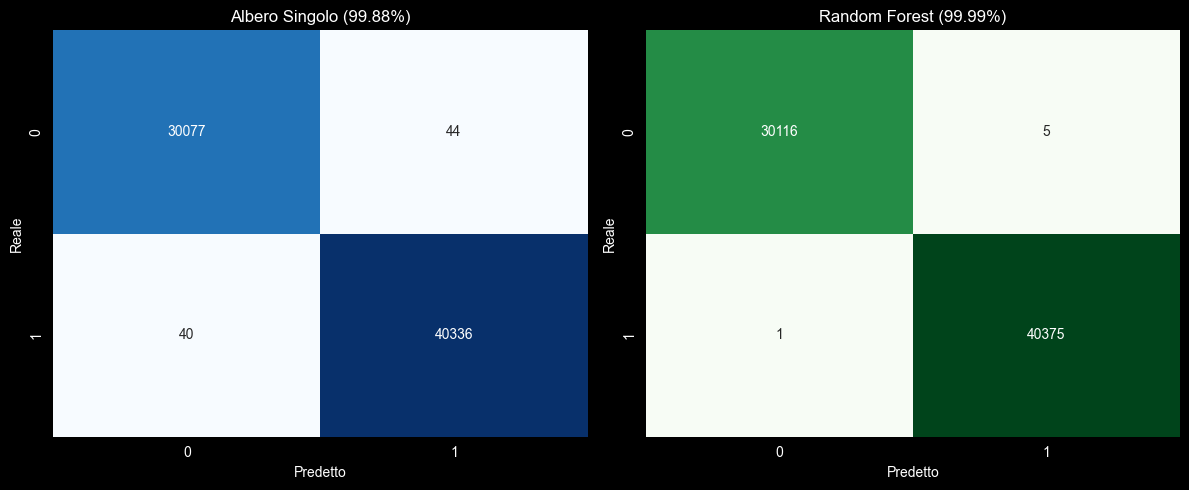


--- CLASSIFICA SECONDO LA RANDOM FOREST ---
LineOfCode: 0.1519
NoOfSelfRef: 0.1457
NoOfExternalRef: 0.1328
NoOfImage: 0.1266
NoOfJS: 0.0587
NoOfCSS: 0.0549
HasCopyrightInfo: 0.0469
HasSocialNet: 0.0464
NoOfOtherSpecialCharsInURL: 0.0348
HasDescription: 0.0328


In [15]:
from sklearn.ensemble import RandomForestClassifier

print("Addestriamo una Random Forest (100 alberi)...")

# Crea la foresta con 100 alberi (n_estimators=100)
# Usa gli stessi dati real

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_real, y_train_real)

# Previsione
y_pred_rf = rf_model.predict(X_test_real)
acc_rf = accuracy_score(y_test_real, y_pred_rf)

print(f"ACCURACY RANDOM FOREST: {acc_rf*100:.2f}%")

# Confronto visivo delle matrici di confusione
plt.figure(figsize=(12, 5))

# Matrice Albero Singolo
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test_real, y_pred_real), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Albero Singolo ({acc_real*100:.2f}%)')
plt.xlabel('Predetto')
plt.ylabel('Reale')

# Matrice Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test_real, y_pred_rf), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Random Forest ({acc_rf*100:.2f}%)')
plt.xlabel('Predetto')
plt.ylabel('Reale')

plt.tight_layout()
plt.show()

# Controlla se la Foresta pensa come l'Albero sulle feature importanti
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1][:10] # Top 10

print("\n--- CLASSIFICA SECONDO LA RANDOM FOREST ---")
for i in indices_rf:
    print(f"{X_real.columns[i]}: {importances_rf[i]:.4f}")

In [16]:
import joblib as jlb
import os

print("6. Salvataggio del modello su file...")

# Creo la cartella 'models'
if not os.path.exists('../models'):
    os.makedirs('../models')

# Salva il migliore modello: Random Forest
# Lo chiamo .pkl (pickle) che è il formato standard di Python per gli oggetti
filename = '../models/phishing_detector_rf.pkl'
jlb.dump(rf_model, filename)

print(f"Modello salvato in: {filename}")
print("Ora puoi chiudere il PC: il modello è al sicuro")

#test di ricaricamento
print("\nProviamo a ricaricarlo per vedere se funziona...")
loaded_model = jlb.load(filename)
result = loaded_model.score(X_test_real, y_test_real)
print(f"Accuracy del modello ricaricato: {result*100:.2f}% (Deve essere 99.99%)")

6. Salvataggio del modello su file...
Modello salvato in: ../models/phishing_detector_rf.pkl
Ora puoi chiudere il PC: il modello è al sicuro

Proviamo a ricaricarlo per vedere se funziona...
Accuracy del modello ricaricato: 99.99% (Deve essere 99.99%)
